Frames extraction


In [2]:
import os
import cv2
from PIL import Image

# Function to extract and compress video frames
def video_to_pil_frames(video_path, output_dir, resize_dim=(224, 224), image_quality=85):
    print(f"Fetching Frames from: {video_path}")
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Load video
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total Frames: {total_frames}")

    for i in range(total_frames):
        ret, frame = video.read()
        if not ret:
            break


        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        

        pil_image = Image.fromarray(frame_rgb)
        

        pil_image = pil_image.resize(resize_dim, Image.Resampling.LANCZOS)
        

        pil_image.save(f"{output_dir}/frame_{i}.jpg", format='JPEG', quality=image_quality)


    video.release()
    print(f"Saved and compressed frames to {output_dir}")

# Define paths
video_path = '/Users/mario/Desktop/Desktop/UofA/4.Winter-2025/ece-910/movies/Batman (1989).mp4'
output_dir = '/Users/mario/Desktop/Desktop/UofA/4.Winter-2025/ece-910/Batman/BATMAN-2/Frames-extraction'

# Extract and compress frames
video_to_pil_frames(video_path, output_dir)


Fetching Frames from: /Users/mario/Desktop/Desktop/UofA/4.Winter-2025/ece-910/movies/Batman (1989).mp4
Total Frames: 181785
Saved and compressed frames to /Users/mario/Desktop/Desktop/UofA/4.Winter-2025/ece-910/Batman/BATMAN-2/Frames-extraction


keyshot


In [3]:
import os
import cv2
import json
import numpy as np
import shutil
import torch
import pandas as pd
from tqdm import tqdm
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from scenedetect import detect, ContentDetector
import time

# Define paths
INPUT_DIR = "/Users/mario/Desktop/Desktop/UofA/4.Winter-2025/ece-910/Batman/BATMAN-2/Frames-extraction"
             
OUTPUT_DIR = "/Users/mario/Desktop/Desktop/UofA/4.Winter-2025/ece-910/Batman/BATMAN-2/histogram-output-sequences"
VIDEO_PATH = "/Users/mario/Desktop/Desktop/UofA/4.Winter-2025/ece-910/movies/Batman (1989).mp4"
JSON_PATH = "/Users/mario/Desktop/Desktop/UofA/4.Winter-2025/ece-910/Batman/BATMAN-2/batman.JSON"
RESULTS_CSV = "/Users/mario/Desktop/Desktop/UofA/4.Winter-2025/ece-910/Batman/BATMAN-2/threshold_results.csv"

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load CLIP (SigLIP) model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to extract image embeddings using SigLIP
def get_image_embedding(image_path):
    """Extract embedding from an image using SigLIP (CLIP)."""
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
    return embedding.squeeze()

# Step 1: Detect shot boundaries using PySceneDetect
def detect_shot_boundaries(video_path):
    print("\n🔍 Detecting shot boundaries...")
    scene_list = detect(video_path, ContentDetector())
    boundaries = [(scene[0].get_frames(), scene[1].get_frames()) for scene in scene_list]
    print(f"✅ Detected {len(boundaries)} sequences.\n")
    return boundaries

# Step 2: Organize frames into sequences
def organize_frames_by_sequence(frame_dir, boundaries):
    print("📂 Organizing frames into sequences...\n")
    frames = sorted([f for f in os.listdir(frame_dir) if f.endswith(".jpg") or f.endswith(".png")])
    
    sequences_metadata = {"sequences": []}

    for i, (start, end) in tqdm(enumerate(boundaries, 1), total=len(boundaries), desc="📂 Organizing Sequences"):
        seq_dir = os.path.join(OUTPUT_DIR, f"sequence_{i}")
        os.makedirs(seq_dir, exist_ok=True)

        for frame in frames:
            frame_num = int(frame.split(".")[0].replace("frame_", ""))
            if start <= frame_num <= end:
                shutil.copy(os.path.join(frame_dir, frame), os.path.join(seq_dir, frame))

        sequences_metadata["sequences"].append({
            "sequence_id": i,
            "start_frame": start,
            "end_frame": end
        })

    # Save JSON file
    with open(JSON_PATH, "w") as json_file:
        json.dump(sequences_metadata, json_file, indent=4)

    print(f"\n✅ JSON metadata saved at: {JSON_PATH}")

# Step 3: Extract keyshots for different threshold values
def extract_keyshots(sequence_dir, hist_threshold, siglip_threshold, method="BHATTACHARYYA"):
    """
    Extract keyshots using Histogram + SigLIP (CLIP) features.
    Varies threshold dynamically for batch evaluation.

    Parameters:
        sequence_dir (str): Path to the sequence directory.
        hist_threshold (float): Histogram threshold.
        siglip_threshold (float): Cosine similarity threshold.
        method (str): Histogram comparison method.

    Returns:
        list: List of keyshot file paths.
    """
    frames = sorted([f for f in os.listdir(sequence_dir) if f.endswith(".jpg") or f.endswith(".png")])
    keyshots = []

    if not frames:
        return keyshots

    prev_hist = None
    prev_embedding = None

    for frame in tqdm(frames, desc=f"📸 Extracting Keyshots ({os.path.basename(sequence_dir)})", leave=False):
        frame_path = os.path.join(sequence_dir, frame)
        image = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)

        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        if prev_hist is None:
            keyshots.append(frame_path)
            prev_hist = hist
            prev_embedding = get_image_embedding(frame_path)
            continue

        # Choose histogram method dynamically
        if method == "BHATTACHARYYA":
            hist_diff = cv2.compareHist(prev_hist, hist, cv2.HISTCMP_BHATTACHARYYA)
        elif method == "CHISQR":
            hist_diff = cv2.compareHist(prev_hist, hist, cv2.HISTCMP_CHISQR)
        elif method == "CORREL":
            hist_diff = cv2.compareHist(prev_hist, hist, cv2.HISTCMP_CORREL)

        # Use histogram difference
        if hist_diff > hist_threshold:
            curr_embedding = get_image_embedding(frame_path)
            similarity = torch.nn.functional.cosine_similarity(prev_embedding, curr_embedding, dim=0)

            # Use SigLIP filtering
            if similarity < siglip_threshold:
                keyshots.append(frame_path)
                prev_embedding = curr_embedding

        prev_hist = hist  # Update previous histogram

    return keyshots


# 🚀 **Run tests with multiple thresholds**
if __name__ == "__main__":
    boundaries = detect_shot_boundaries(VIDEO_PATH)
    organize_frames_by_sequence(INPUT_DIR, boundaries)

    hist_thresholds = [0.2, 0.3, 0.4, 0.5]  # Different thresholds for histogram
    siglip_thresholds = [0.75, 0.8, 0.85, 0.9]  # Different SigLIP similarity thresholds

    results = []

    print("\n🔑 Extracting keyshots with multiple thresholds...\n")
    
    for hist_thresh in hist_thresholds:
        for siglip_thresh in siglip_thresholds:
            start_time = time.time()
            print(f"\n🚀 Running with Hist_Threshold={hist_thresh} | SigLIP_Threshold={siglip_thresh}")

            total_keyshots = 0
            for seq in tqdm(os.listdir(OUTPUT_DIR), desc=f"🔑 Processing Sequences"):
                seq_path = os.path.join(OUTPUT_DIR, seq)
                keyshots = extract_keyshots(seq_path, hist_threshold=hist_thresh, siglip_threshold=siglip_thresh)

                total_keyshots += len(keyshots)

                # Save keyshots in separate folder
                keyshot_dir = os.path.join(seq_path, "keyshots")
                os.makedirs(keyshot_dir, exist_ok=True)

                for shot in keyshots:
                    shutil.copy(shot, os.path.join(keyshot_dir, os.path.basename(shot)))

            end_time = time.time()
            runtime = round(end_time - start_time, 2)

            results.append({
                "Hist_Threshold": hist_thresh,
                "SigLIP_Threshold": siglip_thresh,
                "Total_Keyshots": total_keyshots,
                "Runtime_Seconds": runtime
            })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Save results to CSV
    results_df.to_csv(RESULTS_CSV, index=False)

    print("\n✅ Batch testing complete!")
    print(f"\n📊 Results saved at: {RESULTS_CSV}")


🔍 Detecting shot boundaries...
✅ Detected 1084 sequences.

📂 Organizing frames into sequences...



📂 Organizing Sequences: 100%|██████████| 1084/1084 [01:42<00:00, 10.55it/s]



✅ JSON metadata saved at: /Users/mario/Desktop/Desktop/UofA/4.Winter-2025/ece-910/Batman/BATMAN-2/batman.JSON

🔑 Extracting keyshots with multiple thresholds...


🚀 Running with Hist_Threshold=0.2 | SigLIP_Threshold=0.75


🔑 Processing Sequences: 100%|██████████| 1084/1084 [05:27<00:00,  3.31it/s] 



🚀 Running with Hist_Threshold=0.2 | SigLIP_Threshold=0.8


🔑 Processing Sequences: 100%|██████████| 1084/1084 [04:00<00:00,  4.51it/s] 



🚀 Running with Hist_Threshold=0.2 | SigLIP_Threshold=0.85


🔑 Processing Sequences: 100%|██████████| 1084/1084 [04:05<00:00,  4.42it/s] 



🚀 Running with Hist_Threshold=0.2 | SigLIP_Threshold=0.9


🔑 Processing Sequences: 100%|██████████| 1084/1084 [04:19<00:00,  4.17it/s] 



🚀 Running with Hist_Threshold=0.3 | SigLIP_Threshold=0.75


🔑 Processing Sequences: 100%|██████████| 1084/1084 [03:06<00:00,  5.81it/s] 



🚀 Running with Hist_Threshold=0.3 | SigLIP_Threshold=0.8


🔑 Processing Sequences: 100%|██████████| 1084/1084 [03:07<00:00,  5.78it/s] 



🚀 Running with Hist_Threshold=0.3 | SigLIP_Threshold=0.85


🔑 Processing Sequences: 100%|██████████| 1084/1084 [03:06<00:00,  5.81it/s] 



🚀 Running with Hist_Threshold=0.3 | SigLIP_Threshold=0.9


🔑 Processing Sequences: 100%|██████████| 1084/1084 [03:05<00:00,  5.83it/s] 



🚀 Running with Hist_Threshold=0.4 | SigLIP_Threshold=0.75


🔑 Processing Sequences: 100%|██████████| 1084/1084 [02:31<00:00,  7.16it/s]



🚀 Running with Hist_Threshold=0.4 | SigLIP_Threshold=0.8


🔑 Processing Sequences: 100%|██████████| 1084/1084 [02:37<00:00,  6.88it/s]



🚀 Running with Hist_Threshold=0.4 | SigLIP_Threshold=0.85


🔑 Processing Sequences: 100%|██████████| 1084/1084 [02:41<00:00,  6.73it/s] 



🚀 Running with Hist_Threshold=0.4 | SigLIP_Threshold=0.9


🔑 Processing Sequences: 100%|██████████| 1084/1084 [02:38<00:00,  6.85it/s]



🚀 Running with Hist_Threshold=0.5 | SigLIP_Threshold=0.75


🔑 Processing Sequences: 100%|██████████| 1084/1084 [02:26<00:00,  7.41it/s]



🚀 Running with Hist_Threshold=0.5 | SigLIP_Threshold=0.8


🔑 Processing Sequences: 100%|██████████| 1084/1084 [02:26<00:00,  7.40it/s]



🚀 Running with Hist_Threshold=0.5 | SigLIP_Threshold=0.85


🔑 Processing Sequences: 100%|██████████| 1084/1084 [02:27<00:00,  7.34it/s]



🚀 Running with Hist_Threshold=0.5 | SigLIP_Threshold=0.9


🔑 Processing Sequences: 100%|██████████| 1084/1084 [02:34<00:00,  7.03it/s] 



✅ Batch testing complete!

📊 Results saved at: /Users/mario/Desktop/Desktop/UofA/4.Winter-2025/ece-910/Batman/BATMAN-2/threshold_results.csv


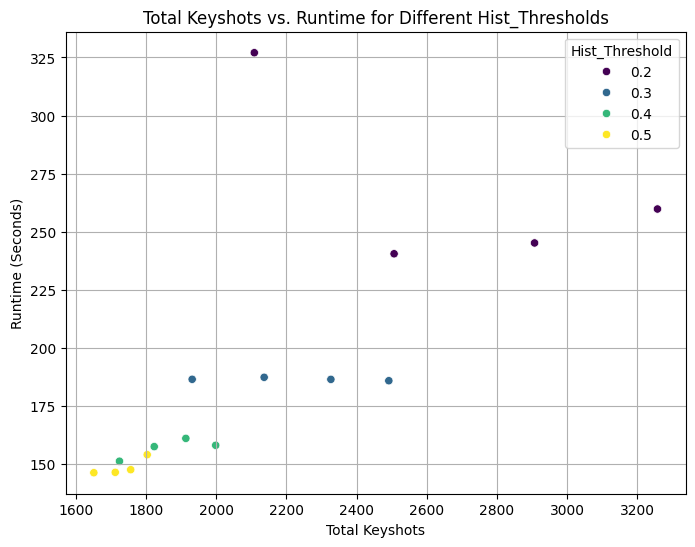

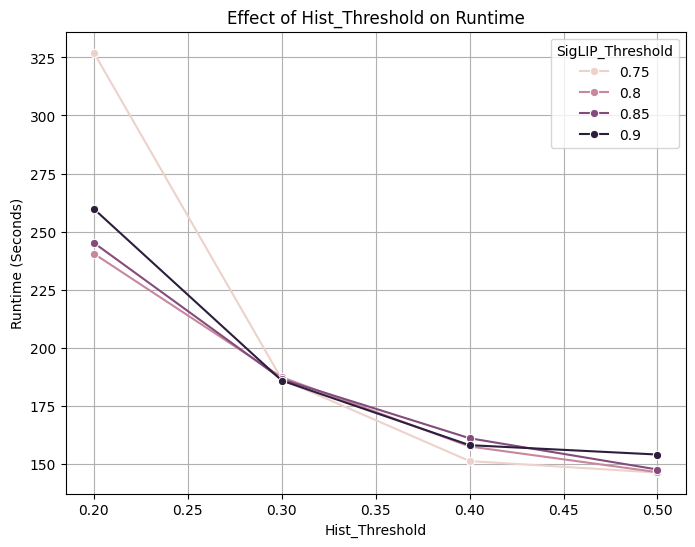

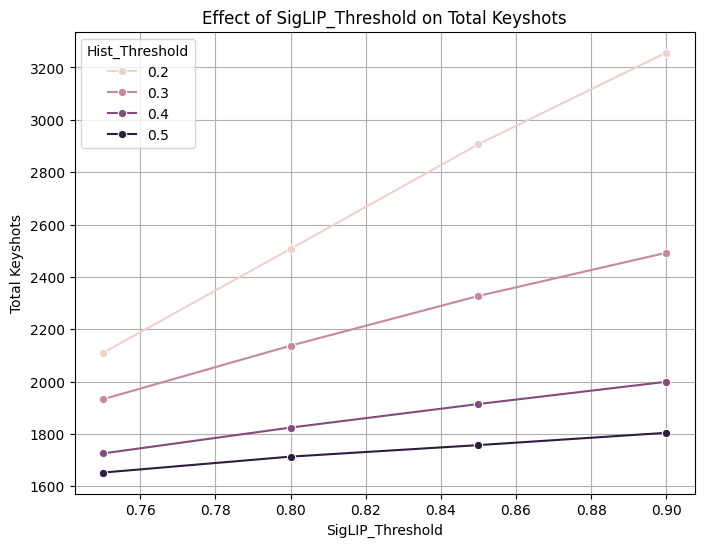

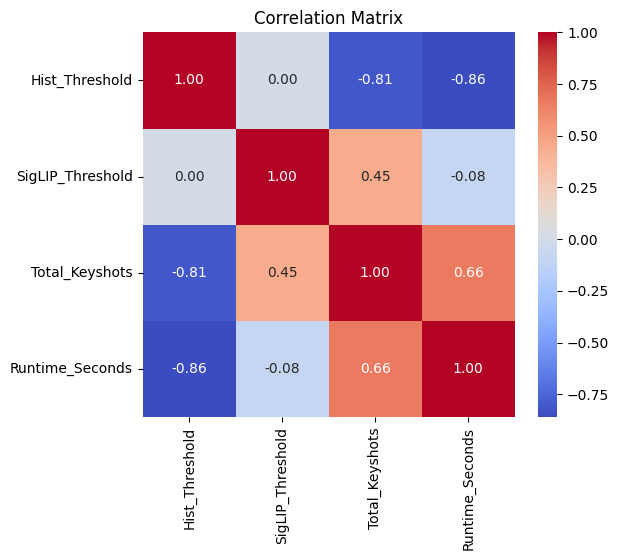


✅ Analysis complete. Results saved to /Users/mario/Desktop/Desktop/UofA/4.Winter-2025/ece-910/Batman/BATMAN-2/processed_threshold_results.csv


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Load the threshold results from your CSV file
threshold_results_path = "/Users/mario/Desktop/Desktop/UofA/4.Winter-2025/ece-910/Batman/BATMAN-2/threshold_results.csv"
threshold_df = pd.read_csv(threshold_results_path)

# 📊 1. Plot Total Keyshots vs. Runtime
plt.figure(figsize=(8, 6))
sns.scatterplot(x=threshold_df["Total_Keyshots"], y=threshold_df["Runtime_Seconds"], hue=threshold_df["Hist_Threshold"], palette="viridis")
plt.title("Total Keyshots vs. Runtime for Different Hist_Thresholds")
plt.xlabel("Total Keyshots")
plt.ylabel("Runtime (Seconds)")
plt.legend(title="Hist_Threshold")
plt.grid(True)
plt.show()

# 📊 2. Analyze Impact of Hist_Threshold on Runtime
plt.figure(figsize=(8, 6))
sns.lineplot(data=threshold_df, x="Hist_Threshold", y="Runtime_Seconds", hue="SigLIP_Threshold", marker="o")
plt.title("Effect of Hist_Threshold on Runtime")
plt.xlabel("Hist_Threshold")
plt.ylabel("Runtime (Seconds)")
plt.grid(True)
plt.show()

# 📊 3. Analyze Impact of SigLIP_Threshold on Total Keyshots
plt.figure(figsize=(8, 6))
sns.lineplot(data=threshold_df, x="SigLIP_Threshold", y="Total_Keyshots", hue="Hist_Threshold", marker="o")
plt.title("Effect of SigLIP_Threshold on Total Keyshots")
plt.xlabel("SigLIP_Threshold")
plt.ylabel("Total Keyshots")
plt.grid(True)
plt.show()

# 📊 4. Correlation Analysis
corr_matrix = threshold_df.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# ✅ Save processed results
output_csv_path = "/Users/mario/Desktop/Desktop/UofA/4.Winter-2025/ece-910/Batman/BATMAN-2/processed_threshold_results.csv"
threshold_df.to_csv(output_csv_path, index=False)
print(f"\n✅ Analysis complete. Results saved to {output_csv_path}")

In [7]:
import os
import cv2
import shutil
import torch
from tqdm import tqdm
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# Define paths
HISTOGRAM_DIR = "/Users/mario/Desktop/Desktop/UofA/4.Winter-2025/ece-910/Batman/BATMAN-2/histogram-output-sequences"
KEYSHOT_DIR = "/Users/mario/Desktop/Desktop/UofA/4.Winter-2025/ece-910/Batman/BATMAN-2/keyshots"

# Ensure keyshots directory exists
os.makedirs(KEYSHOT_DIR, exist_ok=True)

# Load CLIP (SigLIP) model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Threshold values
HIST_THRESHOLD = 0.3
SIGLIP_THRESHOLD = 0.9

# Function to extract image embeddings using SigLIP
def get_image_embedding(image_path):
    """Extract embedding from an image using SigLIP (CLIP)."""
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
    return embedding.squeeze()

# Function to extract keyshots
def extract_keyshots(sequence_dir, keyshot_save_dir, hist_threshold, siglip_threshold, method="BHATTACHARYYA"):
    """Extract keyshots using Histogram + SigLIP (CLIP) features."""
    
    frames = sorted([f for f in os.listdir(sequence_dir) if f.endswith(".jpg") or f.endswith(".png")])
    keyshots = []

    if not frames:
        return keyshots

    prev_hist = None
    prev_embedding = None

    for frame in tqdm(frames, desc=f"📸 Extracting Keyshots ({os.path.basename(sequence_dir)})", leave=False):
        frame_path = os.path.join(sequence_dir, frame)
        image = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)

        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        if prev_hist is None:
            keyshots.append(frame_path)
            prev_hist = hist
            prev_embedding = get_image_embedding(frame_path)
            continue

        # Choose histogram method
        if method == "BHATTACHARYYA":
            hist_diff = cv2.compareHist(prev_hist, hist, cv2.HISTCMP_BHATTACHARYYA)
        elif method == "CHISQR":
            hist_diff = cv2.compareHist(prev_hist, hist, cv2.HISTCMP_CHISQR)
        elif method == "CORREL":
            hist_diff = cv2.compareHist(prev_hist, hist, cv2.HISTCMP_CORREL)

        # Apply histogram difference threshold
        if hist_diff > hist_threshold:
            curr_embedding = get_image_embedding(frame_path)
            similarity = torch.nn.functional.cosine_similarity(prev_embedding, curr_embedding, dim=0)

            # Apply SigLIP filtering
            if similarity < siglip_threshold:
                keyshots.append(frame_path)
                prev_embedding = curr_embedding

        prev_hist = hist  # Update previous histogram

    # Save keyshots in the new keyshot directory
    os.makedirs(keyshot_save_dir, exist_ok=True)
    for shot in keyshots:
        shutil.copy(shot, os.path.join(keyshot_save_dir, os.path.basename(shot)))

    return keyshots

# 🚀 Extract keyshots from all sequences
print("\n🔑 Extracting keyshots using Hist_Threshold = 0.3 & SigLIP_Threshold = 0.9...\n")

for seq in tqdm(os.listdir(HISTOGRAM_DIR), desc=f"🔑 Processing Sequences"):
    seq_path = os.path.join(HISTOGRAM_DIR, seq)
    
    if os.path.isdir(seq_path):  # Ensure it's a directory
        keyshot_save_path = os.path.join(KEYSHOT_DIR, seq)  # Save in the new keyshot directory
        extract_keyshots(seq_path, keyshot_save_path, HIST_THRESHOLD, SIGLIP_THRESHOLD)

print("\n✅ Keyshot extraction complete! Keyshots saved in:")
print(f"📂 {KEYSHOT_DIR}")


🔑 Extracting keyshots using Hist_Threshold = 0.3 & SigLIP_Threshold = 0.9...



🔑 Processing Sequences: 100%|██████████| 1084/1084 [03:01<00:00,  5.98it/s]


✅ Keyshot extraction complete! Keyshots saved in:
📂 /Users/mario/Desktop/Desktop/UofA/4.Winter-2025/ece-910/Batman/BATMAN-2/keyshots
